### 데이터 불러오기

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

basic_df = pd.read_csv("C:\\Users\\seomi\\바탕 화면\\iM Digital academy\\data\\cor_data.csv", encoding='cp949')
ex_df = pd.read_csv("C:\\Users\\seomi\\바탕 화면\\iM Digital academy\\data\\ext_df_corrected.csv")
ex_df.head()

df_merged = basic_df.merge(
    ex_df,
    how='left',
    on=['기준년월', '사업장_시도', '업종_대분류']
)

df_merged = df_merged.dropna(subset=['사업장_시도', '사업장_시군구', '외부_여신시설자금'])
df_merged.to_csv('C:\\Users\\seomi\\바탕 화면\\iM Digital academy\\data\\data_merged.csv', index=False)

df = pd.read_csv("C:\\Users\\seomi\\바탕 화면\\iM Digital academy\\data\\data_merged.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323414 entries, 0 to 323413
Data columns (total 47 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   기준년월         323414 non-null  int64  
 1   업종_대분류       323414 non-null  object 
 2   업종_중분류       323414 non-null  object 
 3   사업장_시도       323414 non-null  object 
 4   사업장_시군구      323414 non-null  object 
 5   법인_고객등급      323414 non-null  object 
 6   전담고객여부       323414 non-null  object 
 7   요구불예금잔액      323414 non-null  float64
 8   거치식예금잔액      323414 non-null  float64
 9   적립식예금잔액      323414 non-null  float64
 10  수익증권잔액       323414 non-null  float64
 11  신탁잔액         323414 non-null  float64
 12  퇴직연금잔액       323414 non-null  float64
 13  여신한도금액       323414 non-null  float64
 14  여신_운전자금대출잔액  323414 non-null  float64
 15  여신_시설자금대출잔액  323414 non-null  float64
 16  외환_수출실적금액    323414 non-null  float64
 17  외환_수입실적금액    323414 non-null  float64
 18  신용카드사용금액     323414 non-

### 범주 -> 수치 매핑

In [81]:
# 범주 -> 수치 매핑

# 1) 건수 매핑 딕셔너리
mapping_count = {
    "0건": 0,
    "1건": 1,
    "2건": 2,
    "2건초과 5건이하": 4,
    "5건초과 10건이하": 8,
    "10건초과 20건이하": 15,
    "20건초과 30건이하": 25,
    "30건초과 40건이하": 35,
    "40건초과 50건이하": 45,
    "50건 초과": 55
}

# 2) 개수 매핑 딕셔너리
mapping_num = {
    "0개": 0,
    "1개": 1,
    "2개": 2,
    "2개초과 5개이하": 4,
    "5개초과 10개이하": 8,
    "10개초과 20개이하": 15,
    "20개초과 30개이하": 25,
    "30개초과 40개이하": 35,
    "40개초과 50개이하": 45,
    "50개 초과": 55
}

# 3) 법인_고객등급 & 전담고객여부 매핑 딕셔너리
mapping_grade = {
    "일반": 0,
    "우수": 0.5,
    "최우수": 1
}

mapping_assign = {
    "N": 0,
    "Y": 1
}

# 4) 매핑할 컬럼 그룹
count_cols = [
    "인터넷뱅킹거래건수", "스마트뱅킹거래건수", "폰뱅킹거래건수", 
    "자동이체거래건수", "창구거래건수", "ATM거래건수",
    "외환_수출실적거래건수","외환_수입실적거래건수"
]

num_cols = [
    "요구불예금좌수","거치식예금좌수","적립식예금좌수",
    "수익증권좌수","신탁좌수","퇴직연금좌수",
    "여신_운전자금대출좌수","여신_시설자금대출좌수",
    "신용카드개수"
]

# 5) 매핑 적용
for col in count_cols:
    df[col] = df[col].map(mapping_count)

for col in num_cols:
    df[col] = df[col].map(mapping_num)

df['법인_고객등급'] = df['법인_고객등급'].map(mapping_grade)
df['전담고객여부'] = df['전담고객여부'].map(mapping_assign)

### 파생변수 생성 및 결측치 처리

In [82]:
# 파생변수

# 채널다양성지수
# 1) 채널별 사용 여부(0/1) 만들기: 금액>0 또는 건수>0 이면 1
df['창구_사용']   = ((df['창구거래금액'].fillna(0)   > 0) | (df['창구거래건수'].fillna(0)   > 0)).astype(int)
df['인터넷_사용'] = ((df['인터넷뱅킹거래금액'].fillna(0) > 0) | (df['인터넷뱅킹거래건수'].fillna(0) > 0)).astype(int)
df['스마트_사용'] = ((df['스마트뱅킹거래금액'].fillna(0) > 0) | (df['스마트뱅킹거래건수'].fillna(0) > 0)).astype(int)
df['폰_사용']     = ((df['폰뱅킹거래금액'].fillna(0)   > 0) | (df['폰뱅킹거래건수'].fillna(0)   > 0)).astype(int)
df['ATM_사용']    = ((df['ATM거래금액'].fillna(0)     > 0) | (df['ATM거래건수'].fillna(0)     > 0)).astype(int)
df['자동이체_사용'] = ((df['자동이체금액'].fillna(0)    > 0) | (df['자동이체거래건수'].fillna(0)  > 0)).astype(int)

# 2) 채널다양성지수 = 사용채널수 / 전체채널수(6)
사용채널_cols = ['창구_사용','인터넷_사용','스마트_사용','폰_사용','ATM_사용','자동이체_사용']
df['채널다양성지수'] = df[사용채널_cols].sum(axis=1) / len(사용채널_cols)

# 대출 다양성 지수
# 대출다변화지수: 잔액이 0보다 크면 1, 아니면 0
df['운전자금대출_사용'] = (df['여신_운전자금대출잔액'].fillna(0) > 0).astype(int)
df['시설자금대출_사용'] = (df['여신_시설자금대출잔액'].fillna(0) > 0).astype(int)

# 총 대출 상품 수 = 2
df['대출다양성지수'] = (df['운전자금대출_사용'] + df['시설자금대출_사용']) / 2

# 교차판매 지수
# 예금군
df['예금_사용'] = (
    (df[['요구불예금잔액','거치식예금잔액','적립식예금잔액']].fillna(0).sum(axis=1) > 0).astype(int)
)

# 대출군
df['대출_사용'] = (
    (df[['여신_운전자금대출잔액','여신_시설자금대출잔액']].fillna(0).sum(axis=1) > 0).astype(int)
)

# 기타군 (투자·신탁·외환 등)
df['기타_사용'] = (
    (df[['수익증권잔액','신탁잔액','퇴직연금잔액','외환_수출실적금액','외환_수입실적금액']]
     .fillna(0).sum(axis=1) > 0).astype(int)
)

# 카드군
df['카드_사용'] = (
    (df[['신용카드사용금액','체크카드사용금액']].fillna(0).sum(axis=1) > 0).astype(int)
)

# ② 교차판매지수 = 사용 상품군 수 / 총 상품군 수(4)
df['교차판매지수'] = (
    df[['예금_사용','대출_사용','기타_사용','카드_사용']].sum(axis=1) / 4
)

# 상품다양성지수
#  ① 상품 좌수 사용 여부 (0/1)
좌수_cols = [
    '요구불예금좌수','거치식예금좌수','적립식예금좌수',
    '수익증권좌수','신탁좌수','퇴직연금좌수'
]

for col in 좌수_cols:
    df[f'{col}_사용'] = (df[col].fillna(0) > 0).astype(int)

# ② 상품다양성지수 = (보유 상품 개수) / (총 상품 좌수 종류 수)
사용좌수_cols = [f'{col}_사용' for col in 좌수_cols]
df['상품다양성지수'] = df[사용좌수_cols].sum(axis=1) / len(좌수_cols)

# 총카드사용금액
df['총카드사용액'] = df['신용카드사용금액'] + df['체크카드사용금액']

# 총예금잔액
df['총예금잔액'] = df['요구불예금잔액'] + df['거치식예금잔액'] + df['적립식예금잔액']

# 총여신잔액
df['총여신잔액'] = df['여신_운전자금대출잔액'] + df['여신_시설자금대출잔액']

# 총투자잔액
df['총투자잔액'] = df['수익증권잔액'] + df['신탁잔액'] + df['퇴직연금잔액']

# 총거래빈도
df['총거래건수'] = df['외환_수출실적거래건수'] + df['외환_수입실적거래건수'] + df['인터넷뱅킹거래건수'] + df['스마트뱅킹거래건수'] + df['폰뱅킹거래건수'] + df['자동이체거래건수'] + df['창구거래건수'] + df['ATM거래건수']

# 총거래금액
df['총거래금액'] = (
    df['창구거래금액'] + df['인터넷뱅킹거래금액'] + df['스마트뱅킹거래금액'] +
    df['폰뱅킹거래금액'] + df['ATM거래금액'] + df['자동이체금액']
)

# 총대출예금잔액
df['대출예금잔액'] = df['총여신잔액'] + df['총예금잔액']

# 컬럼드랍
drop_cols = [
    '창구_사용', '인터넷_사용', '스마트_사용', '폰_사용',
    'ATM_사용', '자동이체_사용', '채널다양성지수',
    '운전자금대출_사용', '시설자금대출_사용', '대출다양성지수',
    '예금_사용', '대출_사용', '기타_사용', '카드_사용',
    '요구불예금좌수_사용', '거치식예금좌수_사용', '적립식예금좌수_사용',
    '수익증권좌수_사용', '신탁좌수_사용', '퇴직연금좌수_사용'
]

df = df.drop(columns=drop_cols)

### LTV + VIP 추출

In [83]:
# 1) 로그 변환 적용 (거래 규모 관련 변수만)
df['대출예금잔액_log'] = np.log1p(df['대출예금잔액'])
df['총거래금액_log'] = np.log1p(df['총거래금액'])
df['총거래건수_log'] = np.log1p(df['총거래건수'])
df['총카드사용액_log'] = np.log1p(df['총카드사용액'])

# 2) 정규화 대상 컬럼 (로그 변환 후 스케일링)
cols_to_scale = ['대출예금잔액_log', '총거래금액_log', '총거래건수_log', '총카드사용액_log']
scaler = MinMaxScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

# 3) LTV 점수 계산 (가중치 반영)
df['LTV_Score'] = (
    0.35 * df['대출예금잔액_log'] +
    0.20 * df['총거래금액_log'] +
    0.20 * df['상품다양성지수'] +
    0.10 * df['총거래건수_log'] +
    0.05 * df['총카드사용액_log'] +
    0.10 * df['법인_고객등급']
)

print(df[['LTV_Score']].head())

   LTV_Score
0   0.211981
1   0.051287
2   0.370521
3   0.390007
4   0.349519


LTV 분포

count    323414.000000
mean          0.356648
std           0.128242
min           0.000000
25%           0.262124
50%           0.356977
75%           0.450040
max           0.795871
Name: LTV_Score, dtype: float64
LTV_Score 상위 33% 기준값: 0.4200


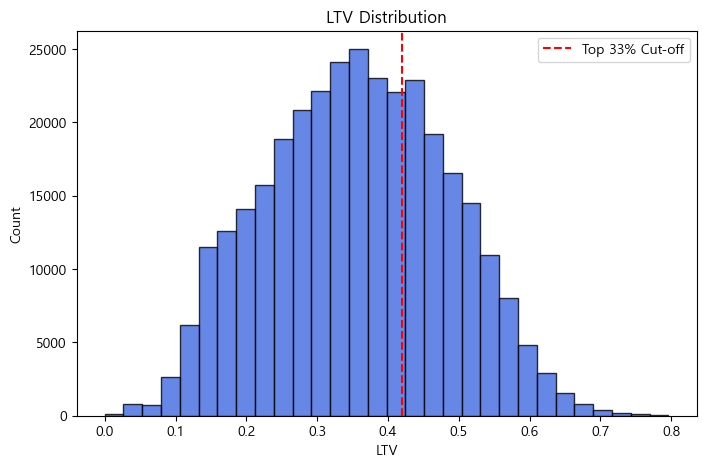

In [84]:
high_value = df[df['LTV_Score'] >= 0]

# 분포 통계 확인
print(high_value['LTV_Score'].describe())
valid_mask = df['LTV_Score'].notna()
cutoff = df.loc[valid_mask, 'LTV_Score'].quantile(0.67)
high_risk = df.loc[valid_mask & (df['LTV_Score'] >= cutoff)]
print(f"LTV_Score 상위 33% 기준값: {cutoff:.4f}")

# 히스토그램으로 시각화 (선택)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.hist(high_value['LTV_Score'], bins=30, color='royalblue', edgecolor='black', alpha=0.8)
plt.axvline(cutoff, color='red', linestyle='--', label='Top 33% Cut-off')
plt.title('LTV Distribution')
plt.xlabel('LTV')
plt.ylabel('Count')
plt.legend()
plt.show()

상위 33% 기준으로 필터링

In [85]:
# 상위 33% 기준값 구하기 (67 분위수)
threshold = df['LTV_Score'].quantile(0.67)
print("상위 33% 기준값:", threshold)

# 기준값 이상만 필터링
vip_df = df[df['LTV_Score'] >= threshold].copy()

drop_cols = [
    '대출예금잔액_log',	'총거래금액_log', '총거래건수_log',	'총카드사용액_log'
]

vip_df = vip_df.drop(columns=drop_cols)

상위 33% 기준값: 0.4200377658885544


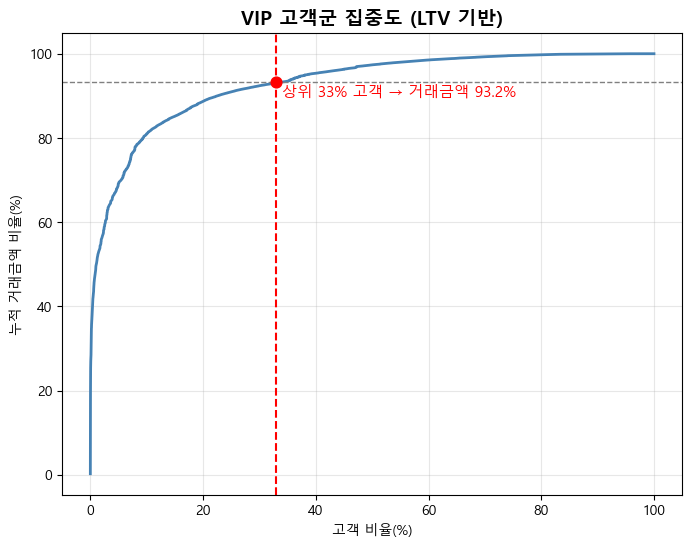

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# LTV 기준으로 내림차순 정렬
df_sorted = df.sort_values('LTV_Score', ascending=False).reset_index(drop=True)

# 누적 거래금액 비율 계산
df_sorted['누적비율'] = df_sorted['총거래금액'].cumsum() / df_sorted['총거래금액'].sum() * 100
df_sorted['고객비율'] = np.arange(1, len(df_sorted) + 1) / len(df_sorted) * 100

# 그래프
plt.figure(figsize=(8,6))
plt.plot(df_sorted['고객비율'], df_sorted['누적비율'], color='steelblue', linewidth=2)
plt.axvline(x=33, color='red', linestyle='--', linewidth=1.5)
plt.axhline(y=93.2, color='gray', linestyle='--', linewidth=1)
plt.scatter(33, 93.2, color='red', s=60, zorder=5)

plt.text(34, 90, '상위 33% 고객 → 거래금액 93.2%', color='red', fontsize=11)
plt.title('VIP 고객군 집중도 (LTV 기반)', fontsize=14, fontweight='bold')
plt.xlabel('고객 비율(%)')
plt.ylabel('누적 거래금액 비율(%)')
plt.grid(alpha=0.3)
plt.show()


세그먼트 별로 나누기

In [87]:
# 1. 그룹 기준 컬럼
group_cols = ['기준년월','업종_대분류', '업종_중분류', '사업장_시도', '사업장_시군구']

# 2. 잔액형 변수(합계로 집계할 컬럼)
sum_cols = [
    '요구불예금잔액', '거치식예금잔액', '적립식예금잔액', '수익증권잔액', '신탁잔액', '퇴직연금잔액',
    '여신한도금액', '여신_운전자금대출잔액', '여신_시설자금대출잔액',
    '외환_수출실적금액', '외환_수입실적금액',
    '신용카드사용금액', '체크카드사용금액', '창구거래금액', '인터넷뱅킹거래금액', '스마트뱅킹거래금액',
    '폰뱅킹거래금액', 'ATM거래금액', '자동이체금액', '요구불입금금액', '요구불출금금액',
    '총카드사용액', '총예금잔액', '총여신잔액', '총투자잔액', '총거래금액', '대출예금잔액'
]

# 3. 평균으로 집계할 컬럼
mean_cols = [col for col in vip_df.columns if col not in group_cols + sum_cols]

# 4. 집계 로직 정의
agg_dict = {col: 'sum' for col in sum_cols}
agg_dict.update({col: 'mean' for col in mean_cols})

# 5. 그룹화 및 집계
vip_grouped = vip_df.groupby(group_cols).agg(agg_dict).reset_index()

# 6. 세그먼트 ID 생성
vip_grouped['세그먼트ID'] = (
    vip_grouped['업종_대분류'].astype(str) + '_' +
    vip_grouped['업종_중분류'].astype(str) + '_' +
    vip_grouped['사업장_시도'].astype(str) + '_' +
    vip_grouped['사업장_시군구'].astype(str)
)

# 7. 불필요한 컬럼 드롭
vip_grouped = vip_grouped.drop(columns=['업종_대분류', '업종_중분류', '사업장_시도', '사업장_시군구'])

# 8. 컬럼 순서 재정렬: 기준년월 → 세그먼트ID → 나머지
cols = ['기준년월', '세그먼트ID'] + [col for col in vip_grouped.columns if col not in ['기준년월', '세그먼트ID']]
vip_grouped = vip_grouped[cols]

# 9. 결과 확인
print(vip_grouped.head())
print(vip_grouped.columns.tolist())

     기준년월                    세그먼트ID  요구불예금잔액  거치식예금잔액  적립식예금잔액  수익증권잔액  \
0  202201  건설업_전문직별 공사업_경기도_안산시 단원구     1.50      0.0      0.0     0.0   
1  202201     건설업_전문직별 공사업_경상남도_김해시     0.00      0.0     10.0     0.0   
2  202201     건설업_전문직별 공사업_경상북도_경산시  4522.80   2672.0    125.6     0.0   
3  202201     건설업_전문직별 공사업_경상북도_경주시   877.58      0.0      0.0     0.0   
4  202201     건설업_전문직별 공사업_경상북도_고령군     0.45      0.0      0.0     0.0   

      신탁잔액   퇴직연금잔액  여신한도금액  여신_운전자금대출잔액  ...  스마트뱅킹거래건수  폰뱅킹거래건수  ATM거래건수  \
0     0.00     0.00     0.0        280.0  ...       0.00      0.0     0.00   
1   130.00   130.00   360.0        310.0  ...       0.00      0.0     0.00   
2  2503.80  1440.80  9480.0      13320.0  ...       0.24      0.0     1.16   
3   124.02   121.62  1510.0       3770.0  ...       0.00      0.0     0.50   
4     0.00     0.00     0.0          0.0  ...      15.00      0.0     0.00   

    자동이체거래건수  외부_여신시설자금  외부_여신운전자금    교차판매지수   상품다양성지수      총거래건수  LTV_Score  
0  15.0

36개월 모두 있는 것만 필터링

In [88]:
# 1. 세그먼트별 개수 집계
seg_counts = vip_grouped['세그먼트ID'].value_counts()

# 2. 36개인 세그먼트만 추출
seg_36 = seg_counts[seg_counts == 36].index

# 3. 원본에서 해당 세그먼트만 필터링
vip_final = vip_grouped[vip_grouped['세그먼트ID'].isin(seg_36)].copy()

### 리스크 스코어 추출 및 이탈여부 생성

리스크스코어 상위 20% 기준값: 0.7453
고위험 세그먼트 개수: 3043


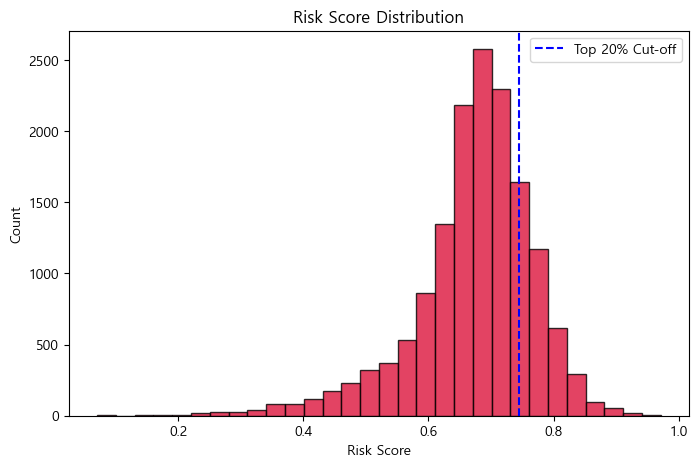

In [89]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
eps = 1e-6
# ------------------------------------------
# 1) 기준월 정렬 (세그먼트별 시계열 정렬)
# ------------------------------------------
# vip_final['기준년월'] = pd.to_datetime(vip_final['기준년월'])  # 필요시 주석 해제
vip_final = vip_final.sort_values(['세그먼트ID', '기준년월'])
g = vip_final.groupby(['세그먼트ID'])
# ------------------------------------------
# 2) 세그먼트별 최근3개월 합 & '바로 이전' 3개월 합 (겹침: shift=1)
#    min_periods=3 → 정확히 3개월 누적이 있는 행만 유효
# ------------------------------------------
recent3_sum = g['총거래금액'].transform(lambda x: x.rolling(window=3, min_periods=3).sum())
prev3_sum   = g['총거래금액'].transform(lambda x: x.rolling(window=3, min_periods=3).sum().shift(1))
# ------------------------------------------
# 3) 거래감소율 = (최근3개월합 - 바로이전3개월합) / (바로이전3개월합)
#    (겹치는 창이므로 첫 3개월만 NaN이 정상)
# ------------------------------------------
vip_final['거래감소율'] = (prev3_sum - recent3_sum) / (prev3_sum + eps)
vip_final['거래감소율'] = vip_final['거래감소율'].clip(-1, 1)  # 과도한 변동 안정화
# ------------------------------------------
# 4) 나머지 변수 계산
# ------------------------------------------
vip_final['대출비중'] = vip_final['총여신잔액'] / (vip_final['총여신잔액'] + vip_final['총예금잔액'] + eps)
# 정규화 (0~1)
cols_to_scale = ['LTV_Score', '대출비중', '거래감소율', '상품다양성지수']
scaler = MinMaxScaler()
vip_final[[c + '_norm' for c in cols_to_scale]] = scaler.fit_transform(vip_final[cols_to_scale])
# ------------------------------------------
# 5) 리스크스코어 계산 (기존 식)
# ------------------------------------------
vip_final['리스크스코어'] = (
    0.35 * (1 - vip_final['LTV_Score_norm']) +
    0.25 * vip_final['대출비중_norm'] +
    0.30 * vip_final['거래감소율_norm'] +
    0.10 * (1 - vip_final['상품다양성지수_norm'])
)
# ------------------------------------------
# 6) 상위 20% 그룹
# ------------------------------------------
valid_mask = vip_final['리스크스코어'].notna()
cutoff = vip_final.loc[valid_mask, '리스크스코어'].quantile(.8)
high_risk = vip_final.loc[valid_mask & (vip_final['리스크스코어'] >= cutoff)]
print(f"리스크스코어 상위 20% 기준값: {cutoff:.4f}")
print(f"고위험 세그먼트 개수: {len(high_risk)}")
# ------------------------------------------
# 7) 시각화
# ------------------------------------------
plt.figure(figsize=(8,5))
plt.hist(vip_final.loc[valid_mask, '리스크스코어'], bins=30, edgecolor='black', color='crimson', alpha=0.8)
plt.axvline(cutoff, color='blue', linestyle='--', label='Top 20% Cut-off')
plt.title('Risk Score Distribution')
plt.xlabel('Risk Score')
plt.ylabel('Count')
plt.legend()
plt.show()

In [90]:
threshold = vip_final['리스크스코어'].quantile(0.8)
vip_final['이탈여부'] = (vip_final['리스크스코어'] >= threshold).astype(int)

In [91]:
vip_final.to_csv("C:\\Users\\seomi\\바탕 화면\\iM Digital academy\\data\\vip_final.csv", index=False)